# Bayesian Linear Regression

This notebook introduces the theory underpinning Bayesian linear regression and provides a python implementation.

## Regression

The goal of regression is to predict the value of one or more continuous target variables $y$ given the value of a $D$-dimensional vector $x$ of input variables. More specifically, given a training data set of $N$ observations $\mathbf{X} = \{x_n\}$, where $n = 1,...,N$, together with corresponding target values $\mathbf{Y} = \{y_n\}$, the task of regression is to predict the value of $y$ for a new value of $x$. The target and observed variates are related through a mapping,

$$f : X \rightarrow Y$$

where $f$ indicates the mapping. In a probabilistic setting we need to consider the uncertainty in both our observations and the mapping $f$. Starting with the relationship between two single input $x_n$ and output $y_n$ points, we can assume a Gaussian likelihood of the form,

$$p(\mathbf{y}_n|f, \mathbf{x}_n) \sim \mathcal{N}(f(\mathbf{x}_n)|\sigma^2 \mathbf{I}) $$

where we have assumed a spherical covariance $\sigma^2 \mathbf{I}$. The off diagonal covariances (which in this case will be zero) are a measure of correlation between the variables so this implies that the variables are decoupled. It can therefore be assumed that the input variables are statistically independent. According to the central limit theorem, which states the average/sum of any i.i.d. samples/variables from any distribution will follow a Gaussian distribution given a sufficiently large data set, means that we can be confident in using a Gaussian distribution.

Assuming each output point is independent given the input point and the mapping $f$, the likelihood can be written in factorised form,

$$p(\mathbf{Y}|f, \mathbf{X}) = \prod\limits_{n=1}^{N} p(\mathbf{y}_n|f, \mathbf{x}_n).$$

In regression, we seek to infer a continuous $\mathbf{y}_n$ from it's corresponding variate $\mathbf{x_n}$. Taking uncertainty into account, we want to reach the posterior distribution over the mapping given the observations,

$$p(f|\mathbf{X}, \mathbf{Y}).$$

## Linear Regression

In linear regression we make the assumption that the mapping between observed and target variates is linear. Here, we further make assumptions about the structure of the noise in our observed data, that it has been corrupted by additive Gaussian noise,

$$\mathbf{y}_n = \mathbf{W} \mathbf{x}_n + \epsilon,$$

where $\epsilon \sim \mathcal{N}(0, \sigma^2 \mathbf{I})$. Assuing each output point is independent given the input point and the mapping, the likelihood can take the form,

$$p(\mathbf{Y} | \mathbf{W}, \mathbf{X}) = \prod\limits_{n=1}^{N} p(\mathbf{y}_n|\mathbf{w}^T \mathbf{x}_n, \sigma^2 \mathbf{I})$$.

We are interested in learning the mapping, i.e. inferring **W** from the data, so our posterior takes the form,

$$p(\mathbf{W} | \mathbf{X}, \mathbf{Y}) = \frac{1}{Z} p(\mathbf{Y} | \mathbf{W}, \mathbf{X}) p(\mathbf{W})$$

We need to formulate our belief about the model parameters **W** in a prior $p(\mathbf{W})$. The prior could take many different forms, however, selecting the conjugate prior is a sensible decision, i.e. a Gaussian prior over the parameters, 

$$p(\mathbf{W}) = \mathcal{N}(\mathbf{W_0}, \tau^2 \mathbf{I})$$.

A conjugate prior is a prior to a parameter in the likelihood function that leads to a posterior that is of the same form as the prior. For the mean in a Gaussian this is another Gaussian while for the covariance it is an Inverse-Whishard distribution.

### Derivation of Posterior over Parameters $p(\mathbf{W}|\mathbf{Y},\mathbf{X}) $

Lets now derive the posterior over parameters **W**, $p(\mathbf{W}|\mathbf{Y},\mathbf{X}) $. First consider the exponent of the general form of the Gaussian distribution,

$$- 1/2(\mathbf{x}-\mathbf{\mu})^T\mathbf{\Sigma}^{ - 1} \mathbf{(x-\mu)} = -1/2\mathbf{x}^T\mathbf{\Sigma}^{ - 1} \mathbf{x} + \mathbf{x}^T\mathbf{\Sigma}^{ - 1} \mathbf{\mu} - 1/2\mathbf{\mu}^T\mathbf{\Sigma}^{ - 1} \mathbf{\mu}$$

The posterior distribution we are trying to derive is $ p(\mathbf{W}|\mathbf{Y},\mathbf{X}) \propto p(\mathbf{Y}|\mathbf{W},\mathbf{X})p(\mathbf{W})$ where the likelihood $p(\mathbf{Y}|\mathbf{W},\mathbf{X})$ and prior $p(\mathbf{W})$ are given by,

\begin{align} 
p(\mathbf{Y}|\mathbf{W},\mathbf{X}) &= \prod_{n=1}^{N}p(\mathbf{y}_n|\mathbf{w},\mathbf{x}_n) = \prod_{n=1}^{N} \mathcal{N}(\mathbf{y}_n|\mathbf{w}^T\mathbf{x}_n, \sigma^2\mathbf{I}) \\
p(\mathbf{W}) &= \mathcal{N}(\mathbf{W}_0, \tau^2\mathbf{I}).
\end{align}

The posterior distribution is therefore equivalent to the product of these distributions. Remembering that $\exp(A)*\exp(B) = \exp(A+B)$, we can multiply out the exponent to get something in a similar form as the exponent of the general form of the Gaussian distribution.

//TODO: Add more detail on derivation

The resulting posterior distribution will be a Gaussian distribution,

$$ p(\mathbf{W}|\mathbf{Y},\mathbf{X}) = \mathcal{N}(\frac{1}{\sigma^2}(\frac{1}{\sigma^2}\mathbf{x}^T\mathbf{x}+\tau^2\mathbf{I})^{-1}\mathbf{x}^T\mathbf{y}, \frac{1}{\sigma^2}\mathbf{x}^T\mathbf{x}+\tau^2\mathbf{I} )$$

We are now ready to start implementing our model.

Note: A Bayesian treatment of linear regression avoids the over-fitting problem of maximum likelihood and leads to automatic methods of determining model complexity using the training data alone.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

We want to show that the approach described above is capable of recovering the true underlying mapping from observed data. In order to test this we first generate some data and then simply throw away the generating parameters.

In [2]:
# create observations
x = np.ones([201, 2])
x[:, 0] = np.linspace(-1, 1, 201)

mu = 0  # mean of observation noise
sigma = 0.3  # variance of observation noise
W = np.array([[-1.3, 0.5]]) # weight parameters [W0 W1]

# generate target data using observations x, weight parameters W and observation noise N(mu, sigma)
y = x @ W.T + np.random.normal(mu, sigma, x[:, 0:1].shape)

Lets display the data so that we know what we are trying to recover.

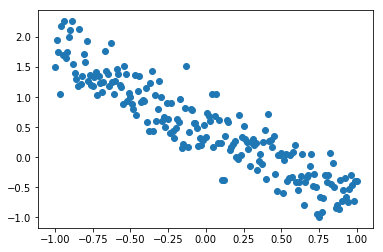

In [3]:
plt.scatter(x[:, 0:1], y[:, 0:1])

We begin our Bayesian treatment of the linear regression problem by introducing a prior probability distribution over the model parameters **W**. We will assume a Gaussian prior distribution, $\mathcal{N}( 0 | 0.5 \mathbf{I}) $.

In [4]:
t = 0.5
prior_var = t * np.eye(W.shape[1])
prior_w = multivariate_normal(mean=[0, 0], cov=prior_var)

Lets create a function that can plot the a distribution over the weight space.

In [5]:
def plot_over_w(dist, title):
    w0, w1 = np.mgrid[-3:1:.01, -1:3:.01]
    pos = np.empty([w0.shape[0], w0.shape[0], 2])
    pos[:, :, 0] = w0; pos[:, :, 1] = w1
    plt.contourf(w0, w1, dist.pdf(pos))
    plt.xlabel('$w_0$', fontsize=16)
    plt.ylabel('$w_1$', fontsize=16)
    plt.title(title, fontsize=16)

Lets visualise the prior distribution over $\mathbf{W}$, $p(\mathbf{W})$.

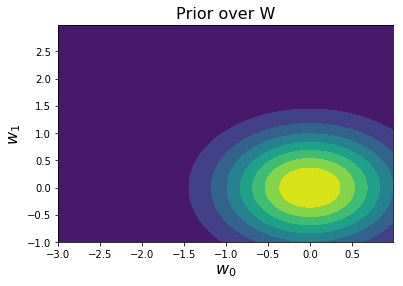

In [6]:
plot_over_w(prior_w, 'Prior over W')

It is clear that the distribution is centered about $(0, 0)$ and that is has a spherical covariance. 

Now lets create a function that can calculate the posterior distribution $p(\mathbf{W} | \mathbf{X}, \mathbf{Y})$. We have forced the posterior distribution to take the form of a Gaussian distribution through the use of a conjugate prior. The posterior is therfore defined by it's mean and covariance.

In [ ]:
def posterior(x, y):
    tI = t * np.identity(x.shape[1])
    m_n = np.linalg.inv((x.T @ x)/sigma + tI) @ x.T @ y / sigma
    s_n_inv = (x.T @ x)/sigma + tI
    s_n = np.linalg.inv(s_n_inv)
    return m_n, s_n

We now create functions that can sample "possible lines" from the posterior and plot them with the input-output data.

In [8]:
def sample_lines(x, y):
    W = np.random.multivariate_normal(m.flatten(), cov=s)
    return x @ W[:, np.newaxis]

def plot_lines(x, y, m, s):
    lines = np.array([sample_lines(x, y) for _ in range(5)]) # sample 5 straight lines from posterior
    plt.plot(x[:, 0], lines[:, :, 0].T, 'r')
    plt.plot(x[:, 0], y, marker='o', linestyle='none', color='b')
    plt.xlabel('$x$',fontsize=16)
    plt.ylabel('$y$',fontsize=16)
    plt.title('Data space (%d data points)' % x.shape[0], fontsize=16)

Lets now visualise our posterior distribution over **W** and sample a couple of functions from it. 


-----Mean and covariance of posterior for all data points-----
mean: [-1.22, 0.50]
covariance: 
[[4.42347390e-03 1.12308207e-19]
 [1.12308207e-19 1.49142431e-03]]


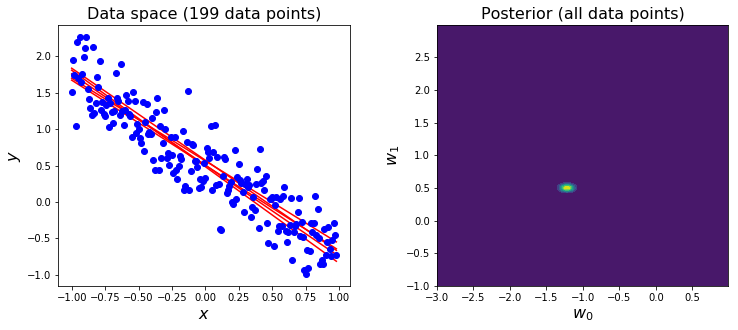

In [37]:
fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# calculate posterior with all data points
m, s = posterior(x, y)
posterior_w = multivariate_normal(mean=m.flatten(), cov=s)

# sample from posterior and plot "possible" lines
plt.subplot(2, 2, 1)
plot_lines(x[:i-1, :], y[:i-1], m, s) 

# plot posterior over w
plt.subplot(2, 2, 2)
plot_over_w(posterior_w, 'Posterior (all data points)')

print("\n-----Mean and covariance of posterior for all data points-----")
print("mean: [%.2f, %.2f]" % (m[0], m[1]))
print("covariance: ")
print(s)

Lets also do this for different numbers of data points.


-----Mean and covariance of posterior for 10 data points-----
mean: [-0.79, 0.98]
covariance: 
[[1.02748956 0.97021965]
 [0.97021965 0.94892872]]

-----Mean and covariance of posterior for 50 data points-----
mean: [-1.24, 0.53]
covariance: 
[[0.24663435 0.18687005]
 [0.18687005 0.14769157]]

-----Mean and covariance of posterior for 200 data points-----
mean: [-1.23, 0.50]
covariance: 
[[4.55788410e-03 4.55445110e-05]
 [4.55445110e-05 1.50685731e-03]]


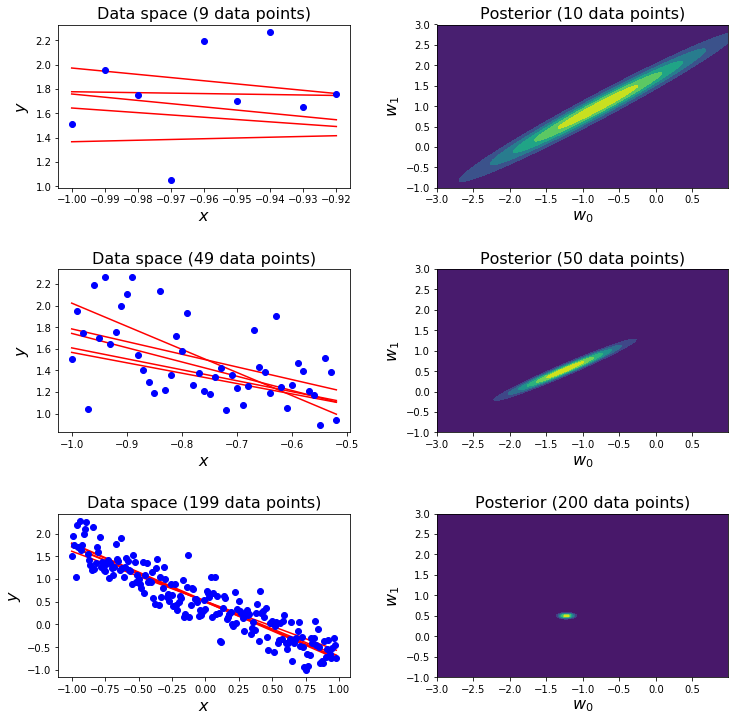

In [38]:
fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

import pprint
pp = pprint.PrettyPrinter(indent=4)

num_data_points = [10, 50, 200]
for index, i in enumerate(num_data_points):
    # calculate posterior for i data points
    m, s = posterior(x[:i-1], y[:i-1])
    posterior_w = multivariate_normal(mean=m.flatten(), cov=s)
    
    print("\n-----Mean and covariance of posterior for %i data points-----" % i)
    print("mean: [%.2f, %.2f]" % (m[0], m[1]))
    print("covariance: ")
    print(s)
    
    # sample from posterior and plot "possible" lines
    plt.subplot(len(num_data_points), 2, 2*index+1)
    plot_lines(x[:i-1, :], y[:i-1], m, s) 
    
    # plot posterior over w
    plt.subplot(len(num_data_points), 2, 2*index+2)
    plot_over_w(posterior_w, 'Posterior (%d data points)' % i)

It is clear that adding more data points improves the model by reducing the variance of the posterior $p(\mathbf{W}|\mathbf{X}, \mathbf{Y})$. The skew in the distribution indicates that the learnt covariance is not spherical, i.e. $w_0$ covaries with $w_1$. The posterior distribution covers a smaller area in the plot because it has a lower variance, i.e. a high certainty about the values of the model parameters $w_0$ and $w_1$.